In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os

import torch
import torch.nn as nn
import torch.nn.utils as utls
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from sklearn.utils import shuffle

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import math

import string
import re
import spacy

from collections import Counter

In [3]:
!pip install torch-summary

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [6]:
cd /content/gdrive/My Drive/AML A2

/content/gdrive/.shortcut-targets-by-id/1Ff-OUTIAl9pGAmjyOGGXOtWzOeBNOvEz/AML A2


In [49]:
# Hyperparameters
path = "./results"        # Give path to your folder to save the csv files
if not os.path.exists(path):
  os.makedirs(path)
train_batch_size = 64
test_batch_size = 32
embed_length = 50    
hid_dim = 64
lr = 0.002
num_epoch = 15
drop_prob = 0.4
n_layers = 1
glove_trainable = True
bidirectional = False
use_glove = True
lemmatize = False

file_name = f"drop({drop_prob})-trainGolve({int(glove_trainable)})-embed({embed_length})-bidir({int(bidirectional)})-lemm({int(lemmatize)})-hidDim({hid_dim})-layers({n_layers})-glove({int(use_glove)}).csv"
final_file = os.path.join(path, file_name)

In [50]:
random_seed = 20
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [9]:
t1 = 'prince'
t2 = 'boy'
t3 = 'girl'
t4 = 'princess'

def semantic_relationship(embedding_dims, t1, t2, t3, t4):
  for i in embedding_dims:
    embed = {}
    with open(f'./GloVe/glove.6B.{i}d.txt', 'r') as f:
      for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embed[word] = coefs
    u = embed[t1] - embed[t2] + embed[t3]
    v = embed[t4]
    w = v-u
    dist = np.linalg.norm(w, 2)
    print(f"For embedding length {i}, the L2 norm of difference is {dist}")

semantic_relationship([50, 100, 200, 300], t1, t2, t3, t4)

For embedding length 50, the L2 norm of difference is 3.2500507831573486
For embedding length 100, the L2 norm of difference is 3.8231987953186035
For embedding length 200, the L2 norm of difference is 5.420839786529541
For embedding length 300, the L2 norm of difference is 5.800549030303955


In [10]:
#### Data Loading ####
df = pd.read_csv("Dataset/IMDB_Dataset.csv")
reviews = df['review']
sentiments = df['sentiment']
mapping = {'negative':0, 'positive':1}
data = reviews.tolist()
labels = [mapping[s] for s in sentiments]
data, labels = shuffle(data, labels)

train_test_frac = 0.8
train_length = int(len(data)*train_test_frac)
X_train = data[:train_length]
y_train = labels[:train_length]
X_test = data[train_length:]
y_test = labels[train_length:]

c_train = Counter(y_train)
print(f"Train Labels: 0 = {c_train[0]}, 1 = {c_train[1]}")

c_test = Counter(y_test)
print(f"Train Labels: 0 = {c_test[0]}, 1 = {c_test[1]}")

Train Labels: 0 = 20023, 1 = 19977
Train Labels: 0 = 4977, 1 = 5023


mean = 231.15694
max = 2470, index = 29676
min = 4, index = 24238


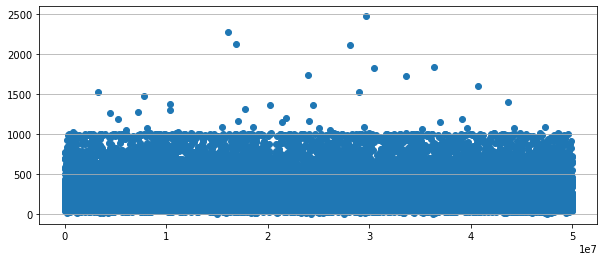

In [11]:
#### Data Visualization ####

length = []
for row in X_train:
  length.append(len(row.split()))
for row in X_test:
  length.append(len(row.split()))

mean = sum(length)/len(length)
print(f'''mean = {mean}
max = {max(length)}, index = {length.index(max(length))}
min = {min(length)}, index = {length.index(min(length))}''')

plt.figure(figsize=(10, 4))
plt.scatter(np.linspace(0, 1000*len(length), len(length)), length)
plt.grid(axis='y')
plt.show()

In [12]:
#@title Lemmatizing Data
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [13]:
if lemmatize:
  X_train = [lemmatize_sentence(i) for i in X_train]
  X_test = [lemmatize_sentence(i) for i in X_test]

In [14]:
tok = spacy.load('en')
def tokenize (text):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(nopunct)]

#Count number of occurences of each word
counts = Counter()
for row in X_train:
    counts.update(tokenize(row))

#Deleting infrequent words
print("Number of words before deletion:",len(counts.keys()))
for word in list(counts):
    if counts[word] < 2:
        del counts[word]
print("Number of words after deletion:",len(counts.keys()))

#Creating the vocabulary
vocab2index = {"<PAD>":0, " ":1, "UNK":2}
words = ["<PAD>", " ", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

VOCAB_SIZE = len(words)
print(f"The Vocab size is {VOCAB_SIZE}")

Number of words before deletion: 90941
Number of words after deletion: 57027
The Vocab size is 57030


In [15]:
maxLen = 240

def encode_sentence(text, vocab2index, N):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc))
    encoded[:length] = enc[:length]
    return encoded

x_train = []
for x in X_train:
    enc = encode_sentence(x, vocab2index, maxLen)
    x_train.append(enc)
x_train = torch.Tensor(x_train)

x_test = []
for x in X_test:
    enc = encode_sentence(x, vocab2index, maxLen)
    x_test.append(enc)
x_test = torch.Tensor(x_test)

In [16]:
y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

In [17]:
class IMDBDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.long().to(device)
        self.y = y.float().to(device)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        sample = self.X[idx], self.y[idx]
        return sample

train_set = IMDBDataset(x_train, y_train)
test_set = IMDBDataset(x_test, y_test)

train_loader = DataLoader(train_set, batch_size=train_batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=test_batch_size, shuffle=False)

In [22]:
#@title Get GloVe Embeddings
embeddings_index = {}
f = open(f'./GloVe/glove.6B.{embed_length}d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print(f'Collecting embeddings from glove.6B.{embed_length}d.txt')
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [23]:
#@title Create Embedding Matrix

cnt = 0
not_found = []

embedding_matrix = np.zeros((VOCAB_SIZE, embed_length))
for word, i in vocab2index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        cnt += 1
        not_found.append(word)
        # embedding_matrix[i] = np.random.uniform(-2, 2, size=(1, embed_length))

embedding_matrix = torch.Tensor(embedding_matrix)

print(f"Number of words not found: {cnt}")
print({word: counts[word] for word in not_found if word != "UNK"})

Number of words not found: 4835
{'<PAD>': 0, ' ': 992206, '  ': 185026, '   ': 120413, '     ': 10250, '    ': 13784, '       ': 2660, 'emptily': 2, 'hrishita': 4, 'cringeworthy': 18, 'disillusions': 3, 'splendini': 4, 'pransky': 6, 'strombel': 8, '      ': 6393, 'recomend': 16, 'attourney': 2, 'virz': 2, 'impacciatore': 3, 'ceccherini': 2, 'dexters': 2, '         ': 835, 'goudurix': 6, 'grossebaf': 2, 'vikea': 2, 'brettschneider': 4, 'schnappmann': 2, 'eburne': 13, 'vaugier': 9, 'tromaville': 10, 'hadn': 438, '            ': 133, 'eisentein': 2, 'almondine': 4, 'unscary': 12, 'noroi': 21, 'garc': 7, 'kresler': 2, 'feinstone': 43, 'volckman': 18, 'tasuiev': 6, 'bislane': 5, 'einstien': 5, 'hollywoodish': 7, 'smtm': 2, '        ': 1668, '          ': 455, 'terpsichorean': 2, 'taelons': 2, 'kannathil': 9, 'muthamittal': 7, 'vellai': 2, 'pookal': 3, 'porkys': 4, 'clunks': 5, 'zosh': 7, 'lucianna': 3, 'paluzzi': 4, 'amphibulos': 4, 'gaillardian': 2, 'tombes': 4, 'godawfull': 2, 'wonderbird

In [24]:
#@title Plot Grad Flow
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.show()

In [25]:
#@title Testing Function

def test(loader, model):
  model.eval()
  predictions = []
  lstm_outs_test = []
  labels = []
  start_time = time.clock()
  with torch.no_grad():
    for x, y in loader:
      out, lstm_out= model(x)

      lstm_outs_test.append(lstm_out.to('cpu').flatten())
      labels += y.cpu().tolist()

      out = torch.sigmoid(out)
      predictions += torch.round(out).cpu().tolist()

  print(f"Test Time       : {time.clock()-start_time}")
  print(f"Predicted Values: {predictions}")
  print(f"Labels          : {labels}")

  print("Accuracy = {:.3f}".format(accuracy_score(labels, predictions)))
  print(confusion_matrix(labels, predictions))
  print("\n")
  cm = confusion_matrix(labels, predictions)
  f1 = f1_score(labels, predictions)
  p = precision_score(labels, predictions)
  r = recall_score(labels, predictions)
  return lstm_outs_test, cm, f1, p, r

In [26]:
#@title Evaluate Function

def evaluate(loader, lstm_model):
  lstm_model.eval()
  predictions = []
  labels = []
  loss_list = []

  start_time = time.clock()
  with torch.no_grad():
    for x, label in loader:
      out, lstm_out= lstm_model(x)

      loss = F.binary_cross_entropy_with_logits(out, label)
      loss_list.append(loss.item())

      labels += label.cpu().tolist()

      out = torch.sigmoid(out.squeeze())
      predictions += torch.round(out).cpu().tolist()

    c = Counter(predictions)
    print(f"Test Outputs: 0 = {c[0]}, 1 = {c[1]}")

  acc = accuracy_score(labels, predictions)
  return acc*100, np.mean(loss_list)

In [27]:
def create_emb_layer(weights_matrix, trainable=False):
    num_embeddings, embedding_dim = weights_matrix.shape
    emb_layer = nn.Embedding(num_embeddings, embedding_dim)
    emb_layer.load_state_dict({'weight': weights_matrix})
    if not trainable:
        emb_layer.weight.requires_grad = False
    return emb_layer

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, bidirectional=False, glove_trainable=False, use_glove=False, dropout_prob=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        if use_glove:
          self.embedding = create_emb_layer(embedding_matrix, glove_trainable)
        else:
          self.embedding = nn.Embedding(VOCAB_SIZE, input_dim)

        if n_layers > 1:
          self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout_prob, bidirectional=bidirectional)
        else:
          self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, bidirectional=bidirectional)

        self.dropout = nn.Dropout(p=dropout_prob)
        
        if bidirectional:
          self.fc = nn.Linear(2*hidden_dim, output_dim)
        else:
          self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        nn.init.normal_(self.fc.weight,0.0,1.0)
        
    def forward(self, x):
        x = self.embedding(x)
        lstm_out, h = self.lstm(x)
        lstm_out = lstm_out[:,-1]
        out = self.dropout(lstm_out)
        out = self.relu(out)
        out = self.fc(out)
        return out.squeeze(), lstm_out

In [28]:
from torchsummary import summary

test_model = LSTMNet(embed_length, 128, 1, 2).to(device)
for x, y in train_loader:
  sample = x
  out, _ = test_model(sample)
  summary(test_model, sample)
  print(f"Output shape: {out.shape}")
  print(f"Input shape: {sample.shape}")
  break

Layer (type:depth-idx)                   Output Shape              Param #
├─Embedding: 1-1                         [-1, 240, 50]             2,851,500
├─LSTM: 1-2                              [-1, 240, 128]            224,256
├─Dropout: 1-3                           [-1, 128]                 --
├─ReLU: 1-4                              [-1, 128]                 --
├─Linear: 1-5                            [-1, 1]                   129
Total params: 3,075,885
Trainable params: 3,075,885
Non-trainable params: 0
Total mult-adds (M): 3.07
Input size (MB): 0.06
Forward/backward pass size (MB): 0.33
Params size (MB): 11.73
Estimated Total Size (MB): 12.12
Output shape: torch.Size([64])
Input shape: torch.Size([64, 240])


In [29]:
def train(train_ldr, test_ldr, n_layers, bidirectional, use_glove, glove_trainable, embed_length=100, learn_rate=1e-06, hidden_dim=32, dropout_prob=0.2, epochs=25):
    # Setting common hyperparameters
    input_dim = embed_length
    output_dim = 1

    train_loss = []
    train_loss_all_epoch = []
    train_acc_all_epoch = []
    train_accu = []
    test_loss = []
    test_accu = []
    train_acc = 0
    test_los = 0
    test_acc = 0
    dataset_len = len(train_ldr)*train_batch_size

    print("######## Hyper Parameters #########")
    print("Hidden Dimension: {}".format(hidden_dim))
    print("Embedding Length: {}".format(embed_length))
    print("Num LSTM layers : {}".format(n_layers))
    print("Glove Embedding : {}".format(use_glove))
    print("Glove Trainable : {}".format(glove_trainable))
    print("Bidirectional   : {}".format(bidirectional))
    print("Learning Rate   : {}".format(learn_rate))
    print("Dropout Prob    : {}".format(dropout_prob))
    print("Batch Size      : {}".format(train_batch_size))
    print("Num Epochs      : {}".format(epochs))
    print("###################################")

    model = LSTMNet(input_dim, hidden_dim, output_dim, n_layers, bidirectional, glove_trainable, use_glove, dropout_prob)
    model.to(device)
    
    # Defining loss function and optimizer
    criterion = nn.BCEWithLogitsLoss()
    # optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate, momentum=0.8)
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    print("\nTraining the Text LSTM model")
    epoch_times = []
    # Start training loop
    for epoch in range(1,epochs+1):
        start_time = time.clock()
        avg_loss = 0.
        counter = 0  
        outs = []
        labels = []
        tLossTemp = 0
        tAccTemp = 0

        model.train()
        model.zero_grad()

        for x, label in train_ldr :
            counter += train_batch_size
            model.zero_grad()

            out, lstm_out = model(x)
            loss = criterion(out, label)
            avg_loss += loss.item()
            loss.backward()
            optimizer.step()
            tLossTemp = tLossTemp + loss.item()
            train_loss.append(avg_loss/counter)

            labels += label.cpu().tolist()
            out = torch.sigmoid(out)
            outs += torch.round(out).cpu().detach().tolist()
            tAccTemp = tAccTemp + (accuracy_score(labels, outs)*100*train_batch_size)

            if counter/train_batch_size%200 == 0:
                train_acc = accuracy_score(labels, outs)*100
                print("Epoch {} | Step: {}/{} | Average Loss for Epoch: {:.4f} | Train Accu: {:.4f} | Time Elapsed: {:.2f}".format(epoch, counter, dataset_len, avg_loss/counter, train_acc, time.clock()-start_time))
        
        train_loss_all_epoch.append(tLossTemp/counter)
        train_acc_all_epoch.append(tAccTemp/counter)
        plot_grad_flow(model.named_parameters())

        current_time = time.clock()
        train_loss.append(avg_loss/counter)
        test_acc, test_los = evaluate(test_loader, model)
        test_accu.append(test_acc)
        test_loss.append(test_los)

        train_acc = accuracy_score(labels, outs)*100
        train_accu.append(train_acc)
        c = Counter(outs)
        print(f"Train Outputs: 0 = {c[0]}, 1 = {c[1]}")

        print("Epoch {}/{} Done | Train Loss: {:.4f} | Train Accu: {:.4f} | Test Loss: {:.4f} | Test Accu: {:.4f} | Time Elapsed: {:.2f}\n".format(epoch, epochs, avg_loss/counter, train_acc, test_los, test_acc, current_time-start_time))
        epoch_times.append(current_time-start_time)
    print("Total Training Time: {} seconds".format(sum(epoch_times)))
    PATH = "./temporary_save.tar"
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss/counter,
                }, PATH)
    return model, train_accu, train_loss, test_accu, test_loss, train_loss_all_epoch, train_acc_all_epoch

Baseline Train Accu: 0.50
Baseline Test Accu : 0.50

######## Hyper Parameters #########
Hidden Dimension: 64
Embedding Length: 50
Num LSTM layers : 1
Glove Embedding : True
Glove Trainable : True
Bidirectional   : False
Learning Rate   : 0.002
Dropout Prob    : 0.4
Batch Size      : 64
Num Epochs      : 15
###################################

Training the Text LSTM model
Epoch 1 | Step: 12800/40000 | Average Loss for Epoch: 0.0109 | Train Accu: 50.9062 | Time Elapsed: 9.02
Epoch 1 | Step: 25600/40000 | Average Loss for Epoch: 0.0108 | Train Accu: 52.8555 | Time Elapsed: 18.96
Epoch 1 | Step: 38400/40000 | Average Loss for Epoch: 0.0107 | Train Accu: 53.3151 | Time Elapsed: 30.09


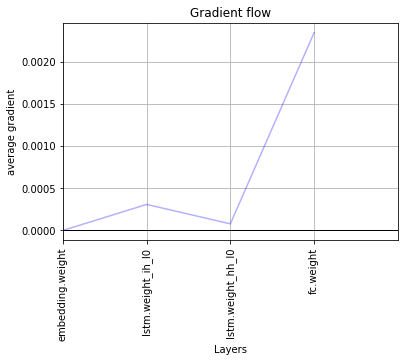

Test Outputs: 0 = 6221, 1 = 3779
Train Outputs: 0 = 17800, 1 = 22200
Epoch 1/15 Done | Train Loss: 0.0107 | Train Accu: 53.2925 | Test Loss: 0.6905 | Test Accu: 51.3000 | Time Elapsed: 31.69

Epoch 2 | Step: 12800/40000 | Average Loss for Epoch: 0.0106 | Train Accu: 55.7891 | Time Elapsed: 9.29
Epoch 2 | Step: 25600/40000 | Average Loss for Epoch: 0.0102 | Train Accu: 59.0977 | Time Elapsed: 19.47
Epoch 2 | Step: 38400/40000 | Average Loss for Epoch: 0.0100 | Train Accu: 62.0260 | Time Elapsed: 30.58


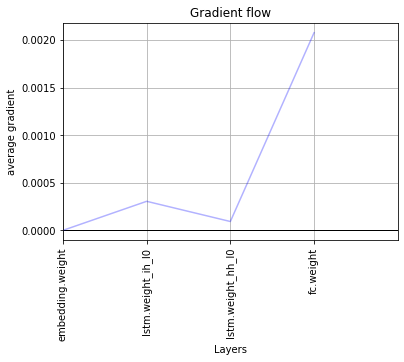

Test Outputs: 0 = 2138, 1 = 7862
Train Outputs: 0 = 21941, 1 = 18059
Epoch 2/15 Done | Train Loss: 0.0100 | Train Accu: 61.7950 | Test Loss: 0.6692 | Test Accu: 56.0300 | Time Elapsed: 32.18

Epoch 3 | Step: 12800/40000 | Average Loss for Epoch: 0.0085 | Train Accu: 75.5781 | Time Elapsed: 7.64
Epoch 3 | Step: 25600/40000 | Average Loss for Epoch: 0.0086 | Train Accu: 74.5000 | Time Elapsed: 16.43
Epoch 3 | Step: 38400/40000 | Average Loss for Epoch: 0.0082 | Train Accu: 76.3620 | Time Elapsed: 27.12


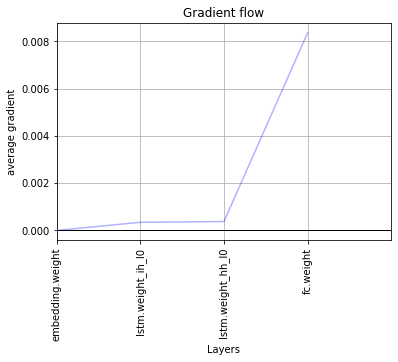

Test Outputs: 0 = 9813, 1 = 187
Train Outputs: 0 = 23007, 1 = 16993
Epoch 3/15 Done | Train Loss: 0.0083 | Train Accu: 75.8500 | Test Loss: 0.6144 | Test Accu: 51.4800 | Time Elapsed: 28.68

Epoch 4 | Step: 12800/40000 | Average Loss for Epoch: 0.0063 | Train Accu: 84.3359 | Time Elapsed: 8.88
Epoch 4 | Step: 25600/40000 | Average Loss for Epoch: 0.0056 | Train Accu: 86.3438 | Time Elapsed: 18.59
Epoch 4 | Step: 38400/40000 | Average Loss for Epoch: 0.0052 | Train Accu: 87.2839 | Time Elapsed: 29.21


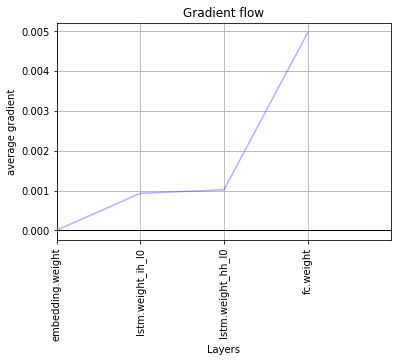

Test Outputs: 0 = 5355, 1 = 4645
Train Outputs: 0 = 19792, 1 = 20208
Epoch 4/15 Done | Train Loss: 0.0051 | Train Accu: 87.4875 | Test Loss: 0.3387 | Test Accu: 86.6600 | Time Elapsed: 30.74

Epoch 5 | Step: 12800/40000 | Average Loss for Epoch: 0.0028 | Train Accu: 93.9453 | Time Elapsed: 8.41
Epoch 5 | Step: 25600/40000 | Average Loss for Epoch: 0.0028 | Train Accu: 94.0078 | Time Elapsed: 17.77
Epoch 5 | Step: 38400/40000 | Average Loss for Epoch: 0.0028 | Train Accu: 94.0026 | Time Elapsed: 28.81


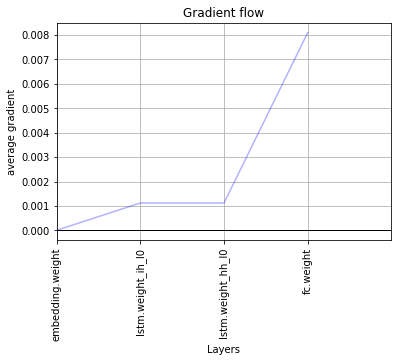

Test Outputs: 0 = 5440, 1 = 4560
Train Outputs: 0 = 19890, 1 = 20110
Epoch 5/15 Done | Train Loss: 0.0028 | Train Accu: 93.9925 | Test Loss: 0.3736 | Test Accu: 86.4100 | Time Elapsed: 30.42

Epoch 6 | Step: 12800/40000 | Average Loss for Epoch: 0.0016 | Train Accu: 97.0234 | Time Elapsed: 8.85
Epoch 6 | Step: 25600/40000 | Average Loss for Epoch: 0.0016 | Train Accu: 96.9531 | Time Elapsed: 18.53
Epoch 6 | Step: 38400/40000 | Average Loss for Epoch: 0.0016 | Train Accu: 96.9792 | Time Elapsed: 29.12


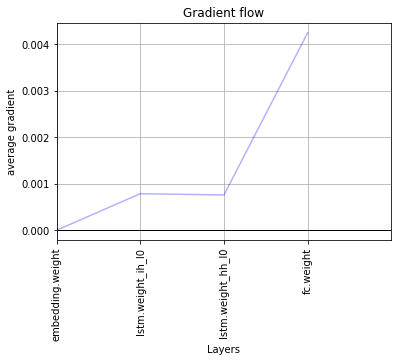

Test Outputs: 0 = 4855, 1 = 5145
Train Outputs: 0 = 20006, 1 = 19994
Epoch 6/15 Done | Train Loss: 0.0016 | Train Accu: 96.9625 | Test Loss: 0.4231 | Test Accu: 86.6200 | Time Elapsed: 30.65

Epoch 7 | Step: 12800/40000 | Average Loss for Epoch: 0.0008 | Train Accu: 98.7500 | Time Elapsed: 9.32
Epoch 7 | Step: 25600/40000 | Average Loss for Epoch: 0.0009 | Train Accu: 98.5977 | Time Elapsed: 19.52
Epoch 7 | Step: 38400/40000 | Average Loss for Epoch: 0.0009 | Train Accu: 98.5417 | Time Elapsed: 30.64


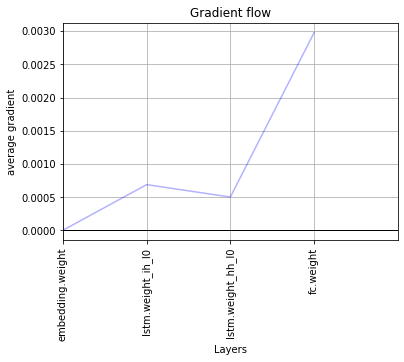

Test Outputs: 0 = 5001, 1 = 4999
Train Outputs: 0 = 19993, 1 = 20007
Epoch 7/15 Done | Train Loss: 0.0009 | Train Accu: 98.5300 | Test Loss: 0.5288 | Test Accu: 86.1800 | Time Elapsed: 32.25

Epoch 8 | Step: 12800/40000 | Average Loss for Epoch: 0.0005 | Train Accu: 99.2109 | Time Elapsed: 8.15
Epoch 8 | Step: 25600/40000 | Average Loss for Epoch: 0.0005 | Train Accu: 99.2031 | Time Elapsed: 17.13
Epoch 8 | Step: 38400/40000 | Average Loss for Epoch: 0.0005 | Train Accu: 99.2266 | Time Elapsed: 28.14


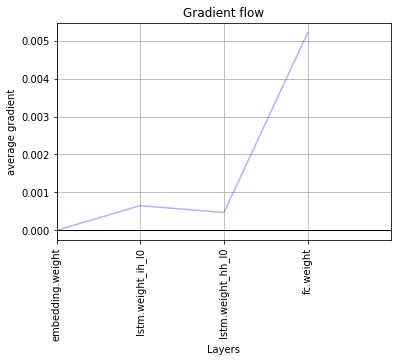

Test Outputs: 0 = 5133, 1 = 4867
Train Outputs: 0 = 20016, 1 = 19984
Epoch 8/15 Done | Train Loss: 0.0005 | Train Accu: 99.2125 | Test Loss: 0.6059 | Test Accu: 85.9600 | Time Elapsed: 29.74

Epoch 9 | Step: 12800/40000 | Average Loss for Epoch: 0.0003 | Train Accu: 99.6484 | Time Elapsed: 8.64
Epoch 9 | Step: 25600/40000 | Average Loss for Epoch: 0.0003 | Train Accu: 99.5508 | Time Elapsed: 18.08
Epoch 9 | Step: 38400/40000 | Average Loss for Epoch: 0.0003 | Train Accu: 99.5417 | Time Elapsed: 28.41


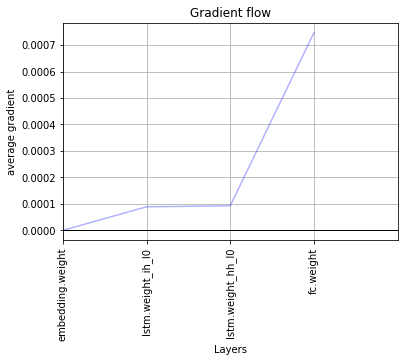

Test Outputs: 0 = 5228, 1 = 4772
Train Outputs: 0 = 20000, 1 = 20000
Epoch 9/15 Done | Train Loss: 0.0003 | Train Accu: 99.5325 | Test Loss: 0.6359 | Test Accu: 85.5500 | Time Elapsed: 29.95

Epoch 10 | Step: 12800/40000 | Average Loss for Epoch: 0.0003 | Train Accu: 99.5234 | Time Elapsed: 7.51
Epoch 10 | Step: 25600/40000 | Average Loss for Epoch: 0.0003 | Train Accu: 99.5938 | Time Elapsed: 15.82
Epoch 10 | Step: 38400/40000 | Average Loss for Epoch: 0.0003 | Train Accu: 99.5885 | Time Elapsed: 25.06


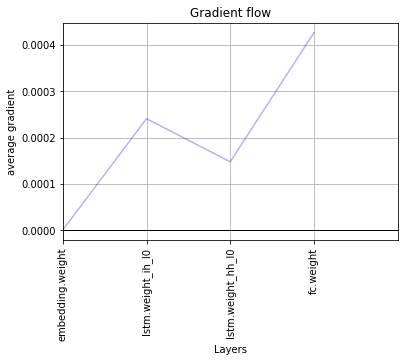

Test Outputs: 0 = 4986, 1 = 5014
Train Outputs: 0 = 20034, 1 = 19966
Epoch 10/15 Done | Train Loss: 0.0003 | Train Accu: 99.5925 | Test Loss: 0.8184 | Test Accu: 85.6700 | Time Elapsed: 26.42

Epoch 11 | Step: 12800/40000 | Average Loss for Epoch: 0.0001 | Train Accu: 99.8516 | Time Elapsed: 7.27
Epoch 11 | Step: 25600/40000 | Average Loss for Epoch: 0.0001 | Train Accu: 99.8320 | Time Elapsed: 15.63
Epoch 11 | Step: 38400/40000 | Average Loss for Epoch: 0.0002 | Train Accu: 99.8125 | Time Elapsed: 26.51


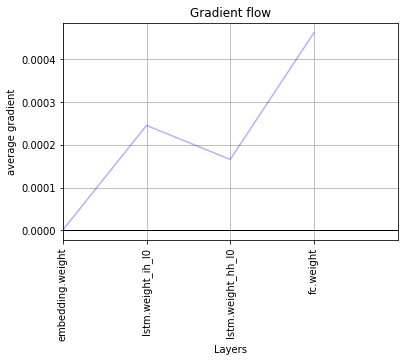

Test Outputs: 0 = 4691, 1 = 5309
Train Outputs: 0 = 20029, 1 = 19971
Epoch 11/15 Done | Train Loss: 0.0002 | Train Accu: 99.8100 | Test Loss: 0.9522 | Test Accu: 85.1800 | Time Elapsed: 28.09

Epoch 12 | Step: 12800/40000 | Average Loss for Epoch: 0.0002 | Train Accu: 99.8516 | Time Elapsed: 8.45
Epoch 12 | Step: 25600/40000 | Average Loss for Epoch: 0.0001 | Train Accu: 99.8516 | Time Elapsed: 17.71
Epoch 12 | Step: 38400/40000 | Average Loss for Epoch: 0.0001 | Train Accu: 99.8542 | Time Elapsed: 27.91


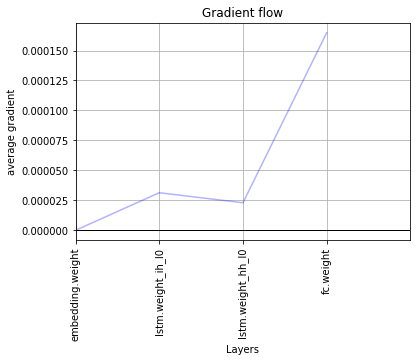

Test Outputs: 0 = 5180, 1 = 4820
Train Outputs: 0 = 20023, 1 = 19977
Epoch 12/15 Done | Train Loss: 0.0001 | Train Accu: 99.8450 | Test Loss: 0.8917 | Test Accu: 85.1700 | Time Elapsed: 29.41

Epoch 13 | Step: 12800/40000 | Average Loss for Epoch: 0.0001 | Train Accu: 99.8359 | Time Elapsed: 7.81
Epoch 13 | Step: 25600/40000 | Average Loss for Epoch: 0.0001 | Train Accu: 99.8516 | Time Elapsed: 16.58
Epoch 13 | Step: 38400/40000 | Average Loss for Epoch: 0.0001 | Train Accu: 99.8021 | Time Elapsed: 27.50


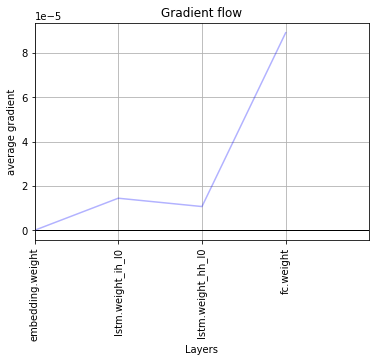

Test Outputs: 0 = 4666, 1 = 5334
Train Outputs: 0 = 20035, 1 = 19965
Epoch 13/15 Done | Train Loss: 0.0001 | Train Accu: 99.7950 | Test Loss: 0.8371 | Test Accu: 84.5500 | Time Elapsed: 29.09

Epoch 14 | Step: 12800/40000 | Average Loss for Epoch: 0.0001 | Train Accu: 99.8594 | Time Elapsed: 9.05
Epoch 14 | Step: 25600/40000 | Average Loss for Epoch: 0.0001 | Train Accu: 99.8711 | Time Elapsed: 18.92
Epoch 14 | Step: 38400/40000 | Average Loss for Epoch: 0.0001 | Train Accu: 99.8385 | Time Elapsed: 29.73


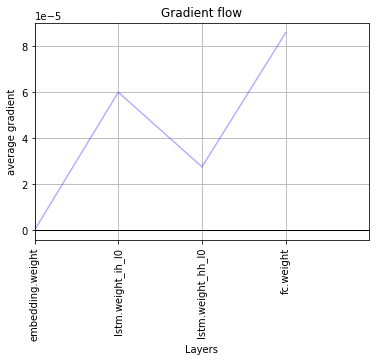

Test Outputs: 0 = 5089, 1 = 4911
Train Outputs: 0 = 20031, 1 = 19969
Epoch 14/15 Done | Train Loss: 0.0001 | Train Accu: 99.8350 | Test Loss: 1.0028 | Test Accu: 85.3800 | Time Elapsed: 31.33

Epoch 15 | Step: 12800/40000 | Average Loss for Epoch: 0.0001 | Train Accu: 99.9062 | Time Elapsed: 7.80
Epoch 15 | Step: 25600/40000 | Average Loss for Epoch: 0.0001 | Train Accu: 99.8828 | Time Elapsed: 16.59
Epoch 15 | Step: 38400/40000 | Average Loss for Epoch: 0.0001 | Train Accu: 99.8516 | Time Elapsed: 27.51


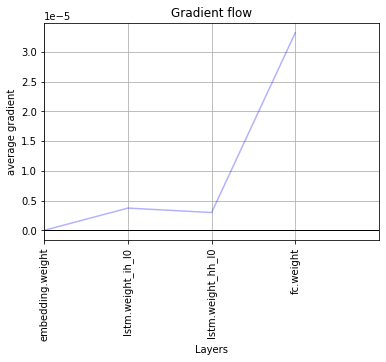

Test Outputs: 0 = 4965, 1 = 5035
Train Outputs: 0 = 20024, 1 = 19976
Epoch 15/15 Done | Train Loss: 0.0001 | Train Accu: 99.8425 | Test Loss: 0.9293 | Test Accu: 85.1000 | Time Elapsed: 29.13

Total Training Time: 449.7617529999993 seconds


In [51]:
print("Baseline Train Accu: {:.2f}".format(max(c_train[0], c_train[1])/len(y_train)))
print("Baseline Test Accu : {:.2f}\n".format(max(c_test[0], c_test[1])/len(y_test)))

lstm_model, train_accu, train_loss, test_accu, test_loss, train_loss_all_epoch, train_acc_all_epoch = train(train_loader, test_loader, n_layers, bidirectional, use_glove, glove_trainable, embed_length, lr, hid_dim, drop_prob, num_epoch)

with open(final_file, 'w+') as f:
  f.write("Epoch,Train Loss,Test Loss,Train Accuracy,Test Accuracy\n")
  for i in range(len(test_loss)):
    f.write(f"{i+1},{train_loss_all_epoch[i]},{test_loss[i]},{train_acc_all_epoch[i]},{test_accu[i]}\n")

In [52]:
_, cm, f1, precision, recall  = test(test_loader, lstm_model)
with open(final_file, "a") as f:
  f.write(f"\ncm:,{cm[0][0]},{cm[0][1]}\n")
  f.write(f",{cm[1][0]},{cm[1][1]}\n")
  f.write(f"f1:,{f1}\n")
  f.write(f"precision:,{precision}\n")
  f.write(f"recall:,{recall}\n")

Test Time       : 4.3249699999996665
Predicted Values: [1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0,